<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

_Author: Unknown_

-----

One of the most common applications for ARIMA models is inventory planning. In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# often necessary b/c pandas & statsmodels datetime issue
import warnings
warnings.simplefilter(action="ignore")

### Importing and exploring the data

After importing, check the following:
- Is there any missing data?
- What are the column datatypes?
- How many observations are there?
- How many unique stores are there?
- How many unique departments are there?

In [2]:
walmart = pd.read_csv('datasets/train.csv')
walmart.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


In [3]:
# missing data?
walmart.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [4]:
# dtypes
walmart.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [5]:
# shape
walmart.shape

(421570, 5)

In [6]:
# number unique stores
len(set(walmart['Store']))

45

In [7]:
# number unique stores
len(set(walmart['Dept']))

81

**Creating a datetime index**

Convert the `Date` column to datetime, and set it as the index for the dataframe.

In [8]:
# Convert "Date" columns 
walmart['Date'] = pd.to_datetime(walmart['Date'])
# Check type datetime64[ns]
walmart.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
dtype: object

In [9]:
# Set index "Date"
walmart = walmart.set_index('Date')
walmart.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


**Getting weekly sales for store 1**

To simplify our work somewhat, we'll consider **only** sales from store 1, and we'll aggregate sales from all departments in store 1.

Create a new dataframe that contains weekly sales for store 1.

> **Note**: You might break this up into multiple steps, or you might do this in one line.
>
> To aggregate, use **groupby**. We're tallying up all sales that have the same date, _not_ aggregating many dates based on year or month.
>
> The only column you'll need to keep is `Weekly_Sales`. You should get rid of the `Store`, `Dept`, and `IsHoliday` columns in your new dataframe.

In [10]:
# # multiple steps, if preferred:
# store_1 = walmart[walmart['Store'] == 1]
# df = store_1.groupby('Date').sum()[['Weekly_Sales']]

In [11]:
# one-liner
df = walmart[walmart['Store'] == 1].groupby('Date').sum()[['Weekly_Sales']]
df.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


---

### Plotting and interpreting a time series

**Generate a line plot**

Generate a line plot for weekly sales, with time on the $x$-axis and sales on the $y$-axis. Make sure the plot has a title, and make sure axes are labeled where appropriate.

In [12]:
# `plot_series` takes in 
# a dataframe, a list of column names to plot, the 
# plot title and the axis labels as arguments,
# then displays the line plot with a figure size
# of 18 horizontal inches by 9 vertical inches.

def plot_series(df, cols, title='Title', xlab=None, ylab=None):
    
    # Set figure size
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name
    for col in cols:
        
        # Generate a line plot of the column name
        # You only have to specify Y, since our
        # index will automatically be the datetime index
        plt.plot(df[col], label=col)
        
    # Generate title and labels
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    # Show legend
    plt.legend();

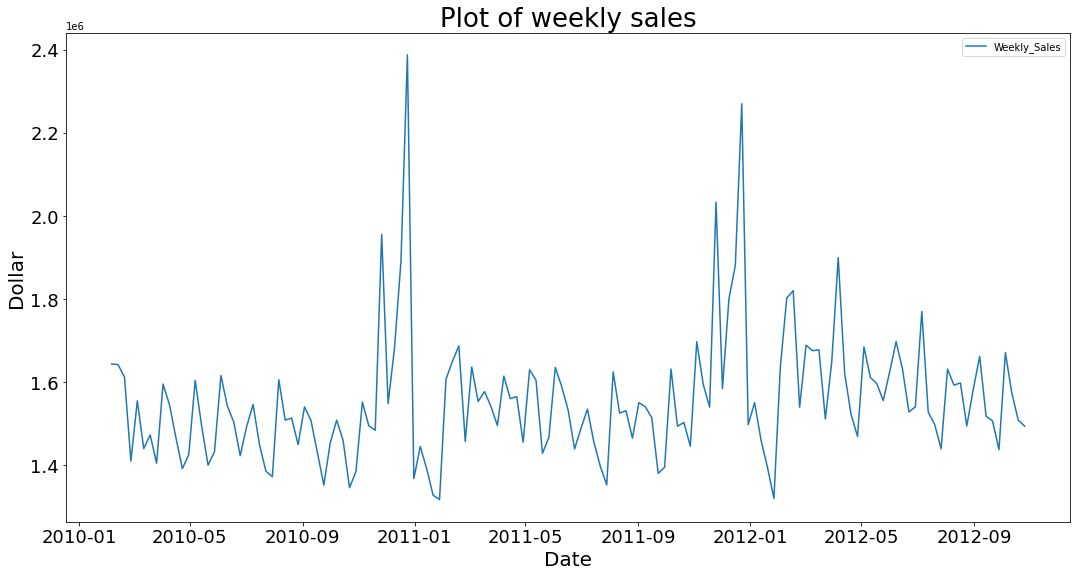

In [13]:
plot_series(df,cols=["Weekly_Sales"], title="Plot of weekly sales", xlab="Date", ylab="Dollar" )

**Plotting rolling means**

Smoothing can help us see trends in the data. On one graph, plot the following:

- Weekly sales
- The 4-week rolling mean of weekly sales
- The 13-week rolling mean of weekly sales
    - (This is included because there are 13 weeks in a business quarter!)

Make sure the plot has a title, axis labels where appropriate, and a legend.

> **(BONUS)**: Add vertical lines on the plot to indicate January 2011 and January 2012.

In [14]:
# Create 4-week and 13-week rolling mean of weekly sales columns
df["4_week_rolling_mean"] = df["Weekly_Sales"].rolling(4).mean()
df["13_week_rolling_mean"] = df["Weekly_Sales"].rolling(13).mean()
df.head()

,Weekly_Sales,4_week_rolling_mean,13_week_rolling_mean
Date,,,
2010-02-05,1643690.90,NaN,NaN
2010-02-12,1641957.44,NaN,NaN
2010-02-19,1611968.17,NaN,NaN
2010-02-26,1409727.59,1576836.025,NaN
2010-03-05,1554806.68,1554614.970,NaN


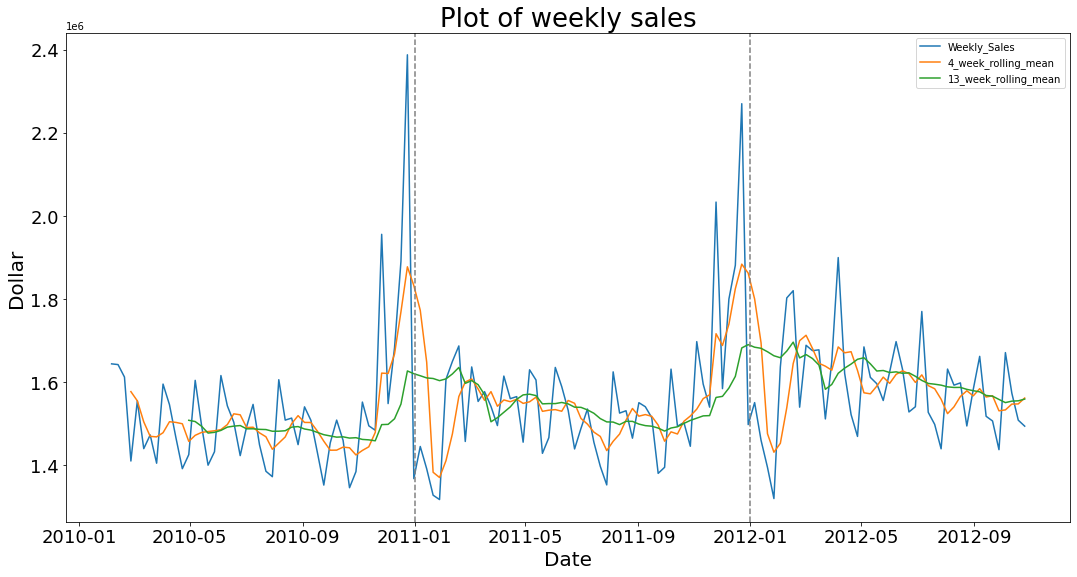

In [15]:
plot_series(df, cols=["Weekly_Sales", "4_week_rolling_mean", "13_week_rolling_mean"], 
            title="Plot of weekly sales", xlab="Date", ylab="Dollar" )

# add vertical lines for start of calendar year
plt.axvline(pd.to_datetime('2011-01-01'), linestyle='--', c='gray')
plt.axvline(pd.to_datetime('2012-01-01'), linestyle='--', c='gray')

**Describe any trends that you notice**

In [16]:
df.sort_values(by="Weekly_Sales", ascending=False).head(4)
# The trends of weekly sales appear to be a seasonality.
# There is an up-and-down pattern during Christmas to New Years festival of each year.
# (fixed and known frequency)

,Weekly_Sales,4_week_rolling_mean,13_week_rolling_mean
Date,,,
2010-12-24,2387950.20,1.877408e+06,1.626602e+06
2011-12-23,2270188.99,1.883783e+06,1.682076e+06
2011-11-25,2033320.66,1.716243e+06,1.562834e+06
2010-11-26,1955624.11,1.621387e+06,1.497383e+06


---

### Autocorrelation and partial autocorrelation

Recall that autocorrelation and partial autocorrelation tell us about how a variable is related to itself at previous lags.

**Plot and interpret the autocorrelation**

Use statsmodels to plot the ACF and PACF. Look at up to **52 lags**. 

What do you notice? Provide a written answer along with your ACF/PACF plots below.

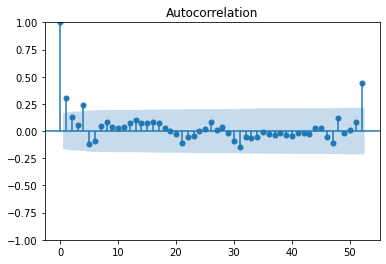

In [17]:
plot_acf(df["Weekly_Sales"], lags=52);
# There's stronger a correlation at lag 1 and at lag 4
# Look pretty noisy until lag 52
# No trend and slightly seasonality (there is small "scalloped")

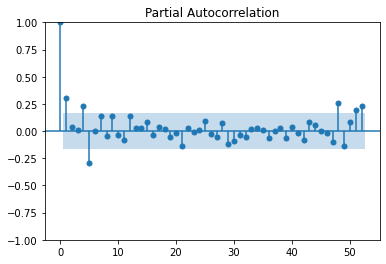

In [18]:
plot_pacf(df["Weekly_Sales"], lags=52, method="ywm");
# There's stronger a correlation at lag 1 and at lag 4
# but a negative correlation at lag 5
# Look pretty noisy until lag 47
# then lags 48 to 52 have strong a correlation

---

### Modeling

**Train-test splitting**

Before fitting a model, we should train-test split. Use the first 90% of observations as training data, and use the remaining 10% as testing data. Remember -- we **do not need to shuffle the data**!

In [19]:
# Generate train/test split
y_train, y_test = train_test_split(df["Weekly_Sales"],
                                   test_size = 0.1,
                                   shuffle=False) # must have for Time Series

In [20]:
# Check shape
y_train.shape , y_test.shape

((128,), (15,))

**Evaluating stationarity**

Use the augmented Dickey-Fuller test to evaluate the weekly sales data, and interpret the result.

In [21]:
# Create function for show only negative number and p-value 
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], 
                         index=['Test Statistic','p-value'])
    return dfoutput

In [22]:
interpret_dftest(adfuller(df["Weekly_Sales"]))
# There is stationary 
# p-value below 0.05 and more negative number
# Reject H0(Not satationary) and thus accept H1(stationary)
# We can use in our model for forecast in time series

Test Statistic   -5.102186
p-value           0.000014
dtype: float64

---

**Fit and evaluate an AR(1) model**

We'll start with a simple autoregressive model with order 1. In statsmodels, an autoregressive model with order $p=1$ can be implemented by instantiating and fitting an ARIMA model with order $(1,0,0)$.

Instantiate and fit your model on the training data.

In [23]:
arima = ARIMA(endog=y_train, order=(1,0,0))
model = arima.fit()

### Evaluating the model

**Store predictions**

Remember that statsmodels ARIMA models generate predictions off of `start` and `end` dates.

Generate and store predictions for the training and testing data.

In [24]:
y_train_preds = model.predict(start = y_train.index[0], end = y_train.index[-1])
y_test_preds = model.predict(start = y_test.index[0], end = y_test.index[-1])

**Mean squared error**

Use the `mean_squared_error` function to identify the MSE on the testing data.

In [25]:
mean_squared_error(y_test, y_test_preds)

5188882502.605215

**Generate a plot of the training data, testing data, train preds, and test preds**

Create a plot showing the training data, testing data, train preds, and test preds. Make sure there are labels and legends.

> **Note**: You'll be making more similar plots. You might consider writing a function to generate your plots!

In [26]:
def plot_preds(y_train, y_test, y_train_preds, y_test_preds, title_label=None):
    
    plt.figure(figsize=(20,10))

    # Plot training data
    plt.plot(y_train.index, y_train.values, color = 'blue', label='training data')

    # Plot testing data
    plt.plot(y_test.index, y_test.values, color = 'orange', label='testing data')

    # Plot predicted train values
    plt.plot(y_train_preds.index, y_train_preds.values, color = 'green', label='training data predict', linestyle='--')
    
    # Plot predicted test values
    plt.plot(y_test_preds.index, y_test_preds.values, color = 'red', label='testing data predict', linestyle='--')

    # Set label
    plt.title(title_label, fontsize=24)

    # Resize tick marks
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend();

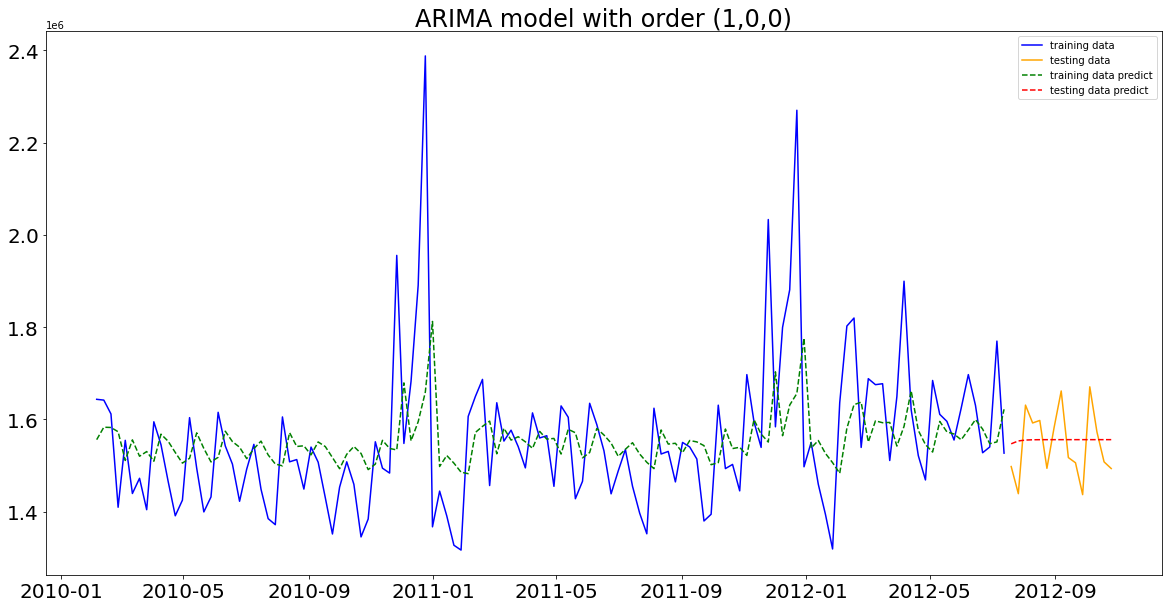

In [27]:
plot_preds(y_train, y_test, y_train_preds, y_test_preds, title_label="ARIMA model with order (1,0,0)")

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [28]:
# The model performs poor.
# Train preds and test preds are not close with train data and test data.

---

**Fit and evaluate an ARMA(2,2) model**

In statsmodels, an autoregressive moving average model with order $p=2$, $q=2$ can be implemented by instantiating and fitting an ARIMA model with order $(2,0,2)$.

Instantiate and fit your model on the training data:

In [29]:
arima = ARIMA(endog=y_train, order=(2,0,2))
model = arima.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [30]:
y_train_preds = model.predict(start = y_train.index[0], end = y_train.index[-1])
y_test_preds = model.predict(start = y_test.index[0], end = y_test.index[-1])

**Mean squared error**

Find the MSE of the testing data.

In [31]:
mean_squared_error(y_test, y_test_preds)

4617986673.802609

**Generate a plot of the training data, testing data, train preds, and test preds**

As before, plot your data and predictions.

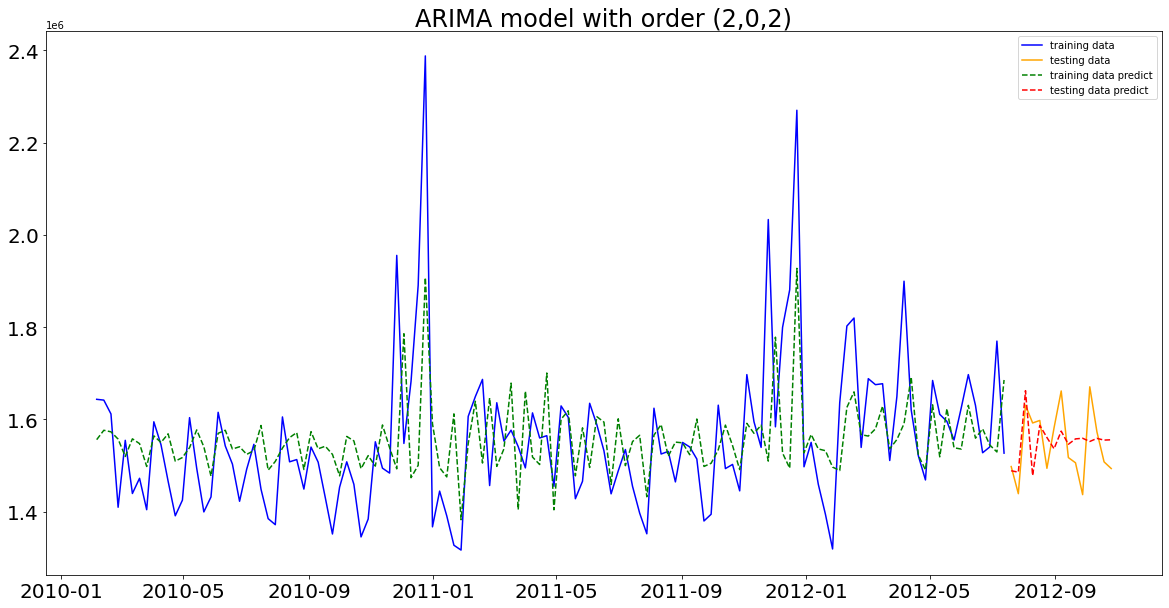

In [32]:
plot_preds(y_train, y_test, y_train_preds, y_test_preds, title_label="ARIMA model with order (2,0,2)")

**Intepretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [33]:
# The model performs better than ARIMA model with order (1,0,0).
# Train preds and test preds are pretty close with train data and test data.

---

**Fit and evaluate an ARIMA(2,1,2) model**

Instantiate and fit an ARIMA model with order $(2,1,2)$.

In [34]:
arima = ARIMA(endog=y_train, order=(2,1,2))
model = arima.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [35]:
y_train_preds = model.predict(start = y_train.index[1], end = y_train.index[-1])
# d = 1 (start index at 1 because first low have NaN)
y_test_preds = model.predict(start = y_test.index[0], end = y_test.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [36]:
mean_squared_error(y_test, y_test_preds)

8383610307.852

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

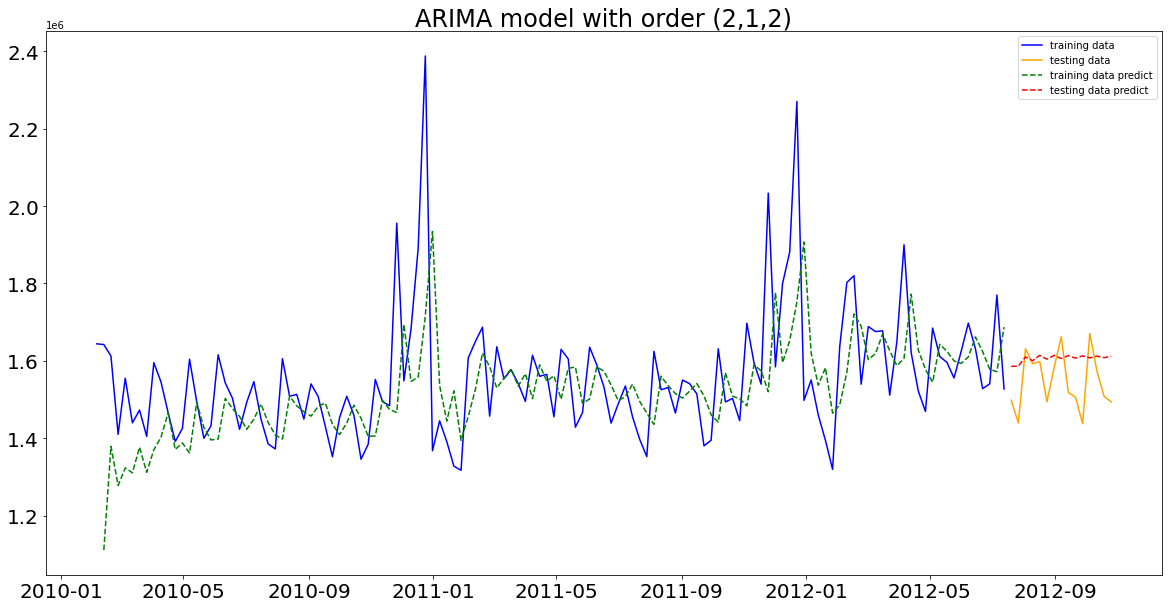

In [37]:
plot_preds(y_train, y_test, y_train_preds, y_test_preds, title_label="ARIMA model with order (2,1,2)")

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [38]:
# The model performs poor.
# Train preds and test preds are not close with train data and test data.
# Test preds show highly value more than mean in test data  

---

### Fit and evaluate an ARIMA(52,0,1) model

The models above use few autoregressive terms and don't do a good job of capturing the long-term trends that we know exist.

Instantiate and fit an ARIMA of order $(52,0,1)$.

In [39]:
arima = ARIMA(endog=y_train, order=(52,0,1))
model = arima.fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [40]:
y_train_preds = model.predict(start = y_train.index[0], end = y_train.index[-1])
y_test_preds = model.predict(start = y_test.index[0], end = y_test.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [41]:
mean_squared_error(y_test, y_test_preds)

7894480470.926959

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

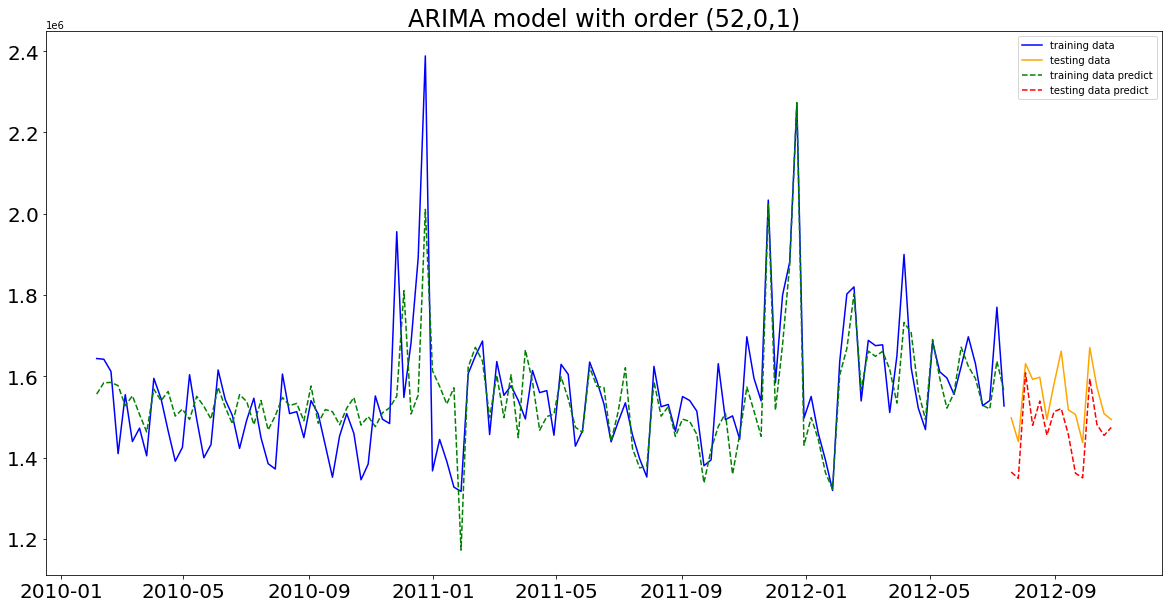

In [42]:
plot_preds(y_train, y_test, y_train_preds, y_test_preds, title_label="ARIMA model with order (52,0,1)")

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [43]:
# The model performs better than all previous ARIMA model 
# Train preds and test preds are pretty close with train data and test data.

---

### SARIMA Modeling

Because of the seasonality of this data, a **seasonal** ARIMA model will perform more strongly.

A SARIMA model has an ARIMA portion which behaves as we expect it to. The S part of a SARIMA model allows us to use seasonal terms. The seasonal part of a SARIMA has order $(P, D, Q)_{m}$. $m$ is the **seasonal period** -- the number of observations per season. $P$, $D$, and $Q$ are somewhat similar to the $p$, $d$, and $q$ terms in an ARIMA model, but $P$, $D$, and $Q$ actually backshift by $m$. 

You can read more about SARIMA models here:
- [PennState SARIMA notes](https://online.stat.psu.edu/stat510/lesson/4/4.1)
- [Forecasting: Principles and Practice 3rd ed.](https://otexts.com/fpp3/seasonal-arima.html)

Fit and evaluate a SARIMA model with order $(2,0,2)$ and seasonal order $(1,1,1,52)$. How well does it perform?

> **Note**: SARIMA models are implemented in statsmodels as SARIMAX - the 'X' part allows [exogenous data](https://en.wikipedia.org/wiki/Exogenous_and_endogenous_variables) to be passed in as well, though we won't specify any.
>
> The seasonal order argument is `seasonal_order`.

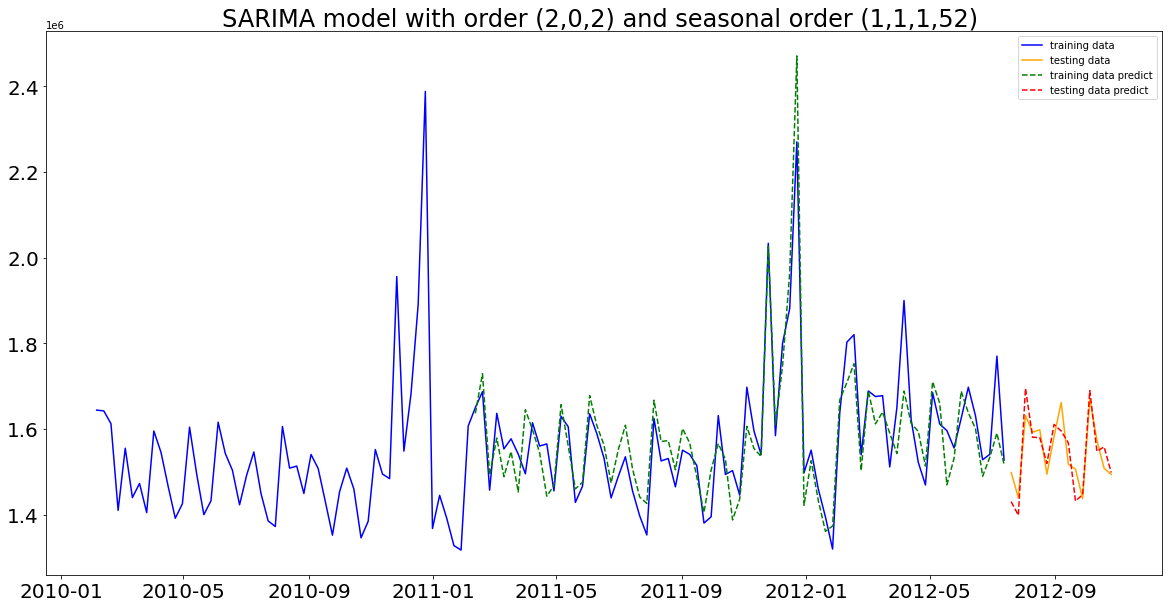

In [44]:
sarima = SARIMAX(y_train, order=(2,0,2), seasonal_order=(1,1,1,52))
model = sarima.fit()

y_train_preds = model.predict(start = y_train.index[53], end = y_train.index[-1])
y_test_preds = model.predict(start = y_test.index[0], end = y_test.index[-1])

plot_preds(y_train, y_test, y_train_preds, y_test_preds, title_label="SARIMA model with order (2,0,2) and seasonal order (1,1,1,52) ")

Our train and test data predictions are more complex and visually better match the data! 
we can get our green line to better match the blue line(train) and can get our red line to better match the orange line(test).

We will assume that our value, $S$, is 52 as it appears (based on the ACF plot and PACF plot) that each season/period is approximately 52 weeks.(1 year)

---